## Exoplanets - Light Curve + Machine Learning
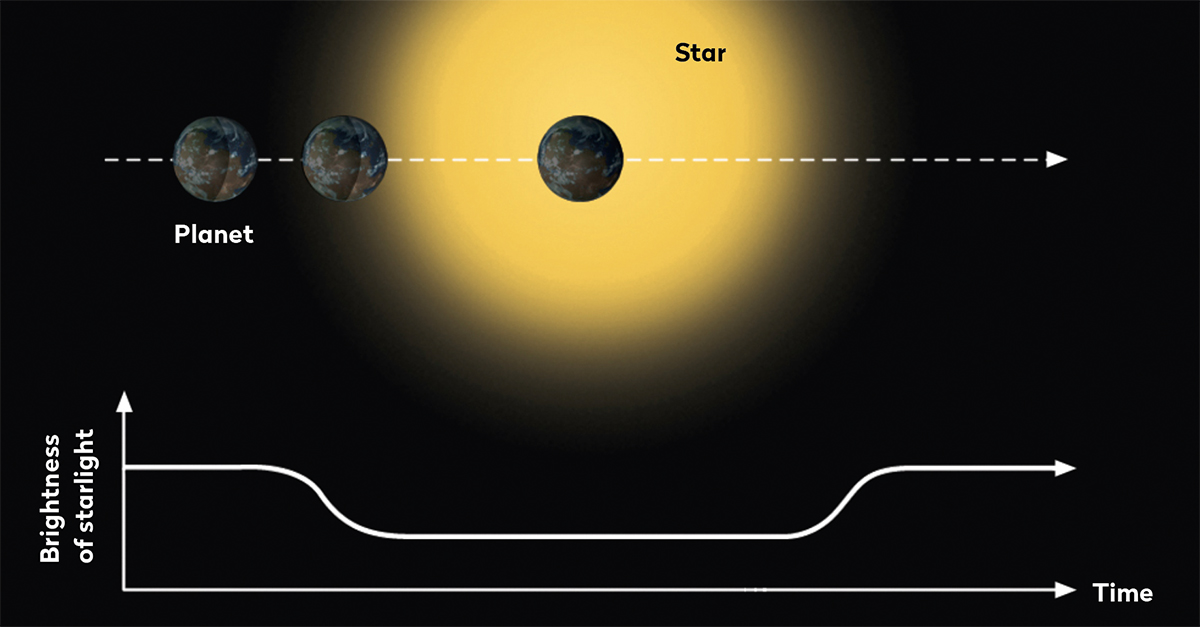

### From The previous Notebook - We explored how we can model a graph of brightness with time, the graph called `a Light Curve`

### In this Notebook, we focus on Machine Learning + Light curve of Exoplanets

### Data collection

The data was collected from the TESS space telescope archive and stored as a CSV file named `TOI.csv` (TESS Objects of Interest).

In [ ]:
## Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
print('current working dir:', os.getcwd())

## load data
data = pd.read_csv('./data/TOI.csv', comment= '#')

In [ ]:
data.head()    

## 1. EDA

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
#data.dtypes

#### We can remove all columns that are not important to our dataset, those are columns that will not contribute to what we aim to achieve

In [ ]:
## drop all irrelevant columns
data = data.drop(['rastr', 'decstr', 'toi_created', 
                 'rowupdate', 'toi', 'tid', 'st_pmraerr1', 'st_pmraerr2'], axis= 1)

In [ ]:
data

In [ ]:
data.dtypes

### We can make a copy of dataset for preprocessing

In [ ]:
df = data.copy()

In [ ]:
# rename tfopwg_disp to just disposition
df.rename(columns= {'tfopwg_disp' : 'disposition'}, inplace= True)

In [ ]:
## check missing targets
df['disposition'].isna().sum()

In [ ]:
# Drop rows where 'disposition' is NaN
df = df.dropna(subset=['disposition'])

In [ ]:
df['disposition'].value_counts()

In [ ]:
# Drop FA since it is not going to help us classify or catagorize the objects
df = df[df['disposition'] != 'FA']

### For our target `disposition` we can map all the above targets into numbers for model simplicisty

####  PC == 1                 CANDIDATE 
####  FP == 2                 False Positive 
####  KP == 3                 Known Planet 
####  CP == 4                 Confirmed Planet 
####  APC == 5                Additional Planet Candidate 

In [ ]:
## the mapping for disposition
disposition_mapping = {'PC': 1,                 # CANDIDATE 
                      'FP': 2,                  # False Positive 
                      'KP': 3,                  # Known Planet 
                      'CP': 4,                  # Confirmed Planet 
                      'APC': 5,                 # Additional Planet Candidate 
}

# Convert the `disposition` column to numeric values
df['disposition'] = df['disposition'].map(disposition_mapping)

In [ ]:
df['disposition'].value_counts()

#### lets check missing values

In [ ]:
## nan
df.isna().mean()

In [ ]:
df.isna().sum().sum()

In [ ]:
# high missing value columns
df.columns[df.isna().mean() >= 1]

### So we can drop these above columns with nan mean greater than 1

In [ ]:
df = df.drop(['pl_insolerr1', 'pl_insolerr2',
              'pl_insollim', 'pl_eqterr1',
              'pl_eqterr2', 'pl_eqtlim'], axis= 1)

In [ ]:
## replace nan with mean of each attribute
numeric_columns = df.select_dtypes(include= ['int64', 'float64']).columns
for column in numeric_columns:
    df[column] = df[column].fillna(df[column].mean())

In [ ]:
## check missing values again
df.isna().mean()

In [ ]:
df.isna().sum().sum()

### No missing values found!!

## 2. Data Visualization

Visualizing the data helps us uncover trends and relationships between key variables.

- **Orbital Period Distribution**: Shows how long exoplanets take to orbit their star. We use the logarithm due to wide variance.
- **Disposition Class Distribution**: Highlights how the target classes are distributed.
- **Radius vs Period**: Helps us examine any relationship between a planet's size and its orbital time.


#### Orbital period is just number of days it takes an exoplanet to go around the parent star

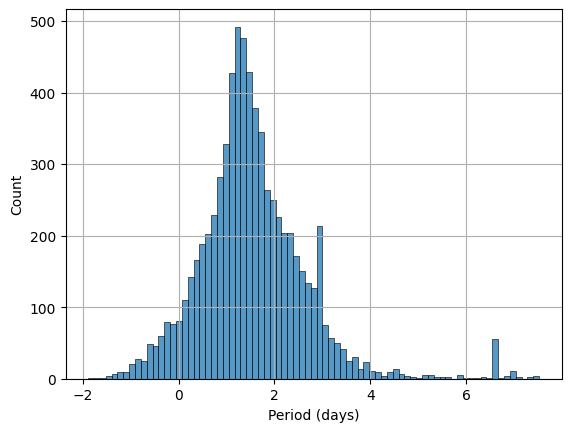

In [209]:
# period distribution
sns.histplot(df['pl_orbper'].apply(np.log))
plt.ylabel('Count')
plt.xlabel('Period (days)')
plt.grid(True)
plt.show()

In [ ]:
'''sns.countplot(df['disposition'].value_counts())
plt.ylabel('Count')
plt.title('Distribution of Disposition Classes')'''

In [ ]:
# plot of disposition classes
target_counts = df['disposition'].value_counts()

plt.figure(figsize= (8, 5))
plt.bar(target_counts.index, target_counts.values)
plt.ylabel('Count')
plt.title('Distribution of Disposition Classes')

plt.show()

In [ ]:
## radius vs period
plt.figure(figsize= (5, 5))

plt.scatter(df['pl_orbper'].apply(np.log), df['pl_rade'].apply(np.log))
plt.ylabel('Radius (Earth-radius)')
plt.xlabel('Period (days)')
plt.grid(True)

plt.show()

## 3. Light Curve

### Background

Defined ealier from notebook `light_curve`

In [ ]:
# Light Curve
from lightkurve import LightCurve
from astropy import units as u
from astropy.stats import sigma_clip

#Load your data
df_lc = pd.read_csv('./data/TrES_2025.07.01_21.30.23.csv', skiprows= 15, low_memory= False, engine= 'c', comment= '#')

### Transit Method

**This is the method used to detect exoplanets (planets outside our solar system) by observing the dips of a star's light as a planet passes in front of it**


In [208]:
'''# Create LightCurve
lc = LightCurve(time= time_mid, flux= flux_v, flux_err= flux_err_v)

# Apply sigma clipping only to flux
clipped_flux = sigma_clip(lc.flux, sigma=3)
clipped_flux_err = sigma_clip(lc.flux_err, sigma=3)

# Create new LightCurve using clipped values (only where valid)
mask = ~clipped_flux.mask
clipped_lc = LightCurve(time=lc.time[mask],
                        flux=lc.flux[mask],
                        flux_err=lc.flux_err[mask])

# Normalize and plot
clipped_lc = clipped_lc.normalize()
clipped_lc.scatter()'''


'# Create LightCurve\nlc = LightCurve(time= time_mid, flux= flux_v, flux_err= flux_err_v)\n\n# Apply sigma clipping only to flux\nclipped_flux = sigma_clip(lc.flux, sigma=3)\nclipped_flux_err = sigma_clip(lc.flux_err, sigma=3)\n\n# Create new LightCurve using clipped values (only where valid)\nmask = ~clipped_flux.mask\nclipped_lc = LightCurve(time=lc.time[mask],\n                        flux=lc.flux[mask],\n                        flux_err=lc.flux_err[mask])\n\n# Normalize and plot\nclipped_lc = clipped_lc.normalize()\nclipped_lc.scatter()'

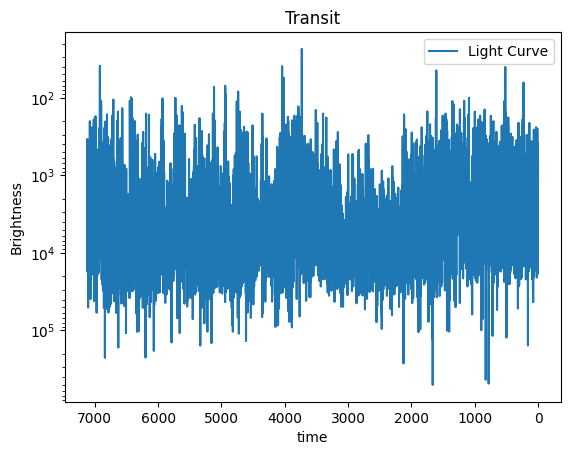

In [203]:
# transit plot                                 
time_nonreal = np.arange(len(df['pl_trandep']))
rolling_avg = df['pl_trandep'].rolling(window= 50).mean() 

plt.plot(time_nonreal ,df['pl_trandep'], label= "Light Curve", markersize= 2)
plt.gca().invert_xaxis()                  # Flip x-axis
plt.gca().invert_yaxis()
plt.yscale('log')                        # Apply log scale


 
plt.xlabel('time')
plt.ylabel('Brightness')
plt.title('Transit')

plt.legend()
plt.show()

####

## 4. Processing

In [ ]:
# copy of df for processing
df = df.copy()

In [ ]:
# define X and y
y = df['disposition']
X = df.drop('disposition', axis= 1)

In [ ]:
X.head()

In [ ]:
y.value_counts()

In [ ]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.90, random_state = 42)

In [ ]:
X_train.shape

In [ ]:
# scaling
Scaler = StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [ ]:
# define ML models in a dictionary
models = { 
        'LogisticRegression': LogisticRegression(), 
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(n_estimators= 70, random_state= 42)
}

In [ ]:
# Train the model
try:
    for name, model in models.items(): 
        model.fit(X_train_scaled, y_train) 
        print(f'The {name} Trained Successfully!')

except Exception as e:
        print(f'All models Failed to train: {e}')    

## 5. Evaluation 

In [ ]:
# pred since all models trained successfully
for name, model in models.items():  
    y_pred = model.predict(X_test_scaled)
    print(f'\nModel: {name}')
    
    # classifications report
    model_accuracy = accuracy_score(y_test, y_pred)
    model_report = classification_report(y_test, y_pred)
    model_confusion_matrix = confusion_matrix(y_test, y_pred)
    
    # display results
    print('model perfomance:')
    print(f'Accuracy: {model_accuracy * 100:.2f}%')
    print('\nClassification report:\n')
    print(model_report)

In [ ]:
# confusion matrix                                  
cm = confusion_matrix(np.array(y_test), y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sb.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues', 
            xticklabels=['Candidate', 'FP', 'Known', 'Confirmed', 'Additional'], 
            yticklabels=['Candidate', 'FP', 'Known', 'Confirmed', 'Additional'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

# Rotate x-axis labels
plt.xticks(rotation= 30)
plt.yticks(rotation= 30)

plt.show()

In [ ]:
## The model may need to be improved in future

## Save the model

In [ ]:
import joblib  

# trained model
joblib.dump(model, 'model.pkl')

In [ ]:
df.to_csv('./models/model.csv', index= False)

In [ ]:
print(df.columns)

### Future considerations??

To improve the model and gain deeper insights, we suggest:
- Trying advanced models like XGBoost or SVM
- Applying hyperparameter tuning
- Using K-Fold Cross-Validation
- Adding more visualizations for key attributes


## References

- [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/)
- [Lightkurve Documentation](https://docs.lightkurve.org/)
- [Astropy](https://www.astropy.org/)
- [Scikit-learn](https://scikit-learn.org/)
